# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.741086,True,7.054174
1,0.730361,False,-0.203298
2,1.970057,True,6.320687
3,0.100670,False,-2.137791
4,0.311545,False,-0.229810
...,...,...,...
995,2.397114,True,8.286518
996,1.428930,True,4.587663
997,0.951938,True,5.326942
998,0.572114,True,7.067889


<AxesSubplot:xlabel='v0'>

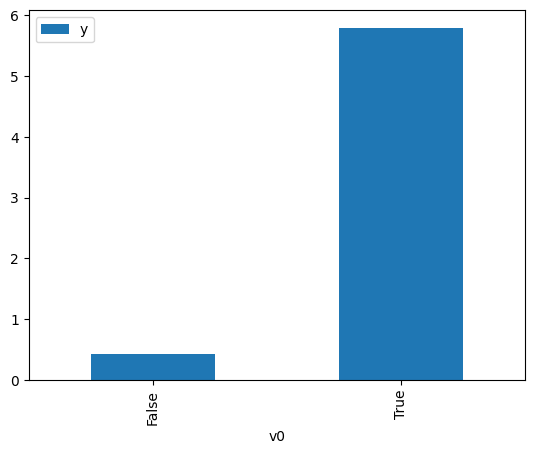

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

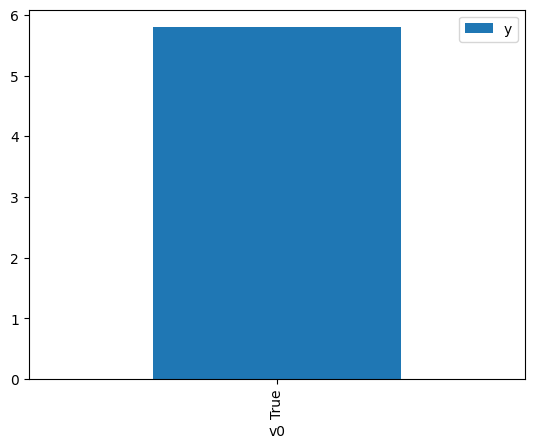

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.616998,False,1.443324,0.214074,4.671283
1,0.531676,False,0.652158,0.247845,4.034772
2,0.087670,False,-0.426195,0.470212,2.126699
3,1.284312,False,2.812675,0.057882,17.276491
4,1.673335,False,-0.617396,0.025139,39.778547
...,...,...,...,...,...
995,-0.516609,False,-0.856019,0.773682,1.292521
996,1.020380,False,1.232339,0.099685,10.031607
997,0.782937,False,1.676757,0.158310,6.316701
998,0.334783,False,-0.226060,0.338329,2.955701


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.803909,True,5.343005,0.847826,1.179487
1,0.202923,True,6.439316,0.593026,1.686266
2,1.324367,True,6.741620,0.946804,1.056185
3,1.064998,True,6.773536,0.908902,1.100229
4,-0.049402,True,7.197514,0.453485,2.205145
...,...,...,...,...,...
995,-0.510964,True,5.179475,0.228531,4.375773
996,1.903106,True,6.059092,0.984792,1.015443
997,0.676631,True,5.348730,0.807465,1.238444
998,0.074596,True,5.834224,0.522514,1.913825


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.431e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:18:16   Log-Likelihood:                         -1397.8
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     998   BIC:                                      2809.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2942      0.039     33.260      0.000       1.218       1.371
x2             4.9218      0.055     89.739      0.000       4.814       5.029
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.643
Skew:                          -0.081   Prob(JB):                        0.440
Kurtosis:                       2.885   Cond. No.                         2.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""